<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Общая-информация" data-toc-modified-id="Общая-информация-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Общая информация</a></span></li><li><span><a href="#Очистка-и-лемматизация" data-toc-modified-id="Очистка-и-лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очистка и лемматизация</a></span></li><li><span><a href="#Разбивка-данных-на-выборки" data-toc-modified-id="Разбивка-данных-на-выборки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Разбивка данных на выборки</a></span></li><li><span><a href="#Уменьшение-выборки" data-toc-modified-id="Уменьшение-выборки-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Уменьшение выборки</a></span></li><li><span><a href="#Преобразование-признаков-в-матрицу" data-toc-modified-id="Преобразование-признаков-в-матрицу-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Преобразование признаков в матрицу</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Сравнение-результатов" data-toc-modified-id="Сравнение-результатов-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Сравнение результатов</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Определение токсичных комментариев

Интернет-магазину требуется инструмент для анализа комментариев пользователей на английском языке и определения токсичных для отправки на модерацию. Необходимо обучить модель по классификации комментариев на позитивные и негативные со значением метрики F1 не меньше 0.75.

В распоряжении имеется набор данных с разметкой о токсичности правок.

**План исследования**

1. Загрузка и подготовка данных
2. Обучение нескольких моделей
3. Тестирование лучшей модели
4. Общий вывод

## Подготовка данных

### Общая информация

Проведем необходимые установки и импорты библиотек:

In [1]:
# Загрузим пакет spaCy
import sys
!{sys.executable} -m pip install spacy

# Загрузим модель 'en' (английский язык)
!{sys.executable} -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.6 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

import numpy as np
np.set_printoptions(threshold=np.inf)

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
tqdm.pandas()

import re
import spacy

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

Загрузим данные:

In [3]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv') 
except:
    data = pd.read_csv('/Users/Dasha/ml_for_text_project_toxic_comments/toxic_comments.csv')

Изучим общую информацию о данных:

In [4]:
# для работы дублируем датасет, чтобы не вносить изменения в исходный файл
data_new = data.copy()

#выводим первые 15 строк таблицы
display(data_new.head(15))
    
#выводим информацию о датасете
display(data_new.info())
    
#выводим описательную статистику данных
display(data_new.describe())
    
#проверяем наличие явных дубликатов в объектах
print('Количество явных дубликатов в объектах:', data_new.duplicated().sum())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Количество явных дубликатов в объектах: 0


Явные дубликаты и пропуски в данных отсутствуют, тип данных в порядке. Текст сырой - в нем присутствуют лишние символы, необходима лемматизация. В целевом признаке токсичные комментарии относятся к классу 1, остальные - к классу 0 (бинарная классификация).

Посмотрим на распределение целевого класса:

In [5]:
data_new['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

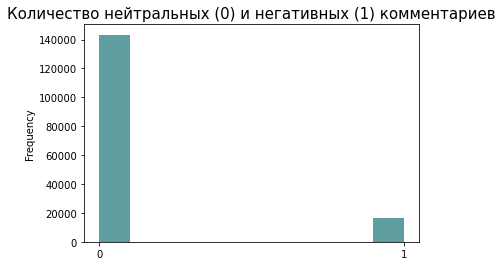

In [6]:
data_new['toxic'].plot(kind='hist', color='cadetblue')
plt.title('Количество нейтральных (0) и негативных (1) комментариев', fontsize=(15))
plt.xticks(np.arange(min(data_new['toxic']), max(data_new['toxic'])+1, 1))

plt.show()

Целевой класс распределен неравномерно - положительных объектов лишь 9% от всей выборки.

### Очистка и лемматизация

Проведем лемматизацию с помощью пакета *spaCy* - он по умолчанию определяет часть речи и назначает соответствующую лемму,  POS-таг не требуется.

In [7]:
# объявление модели SpaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Напишем функцию для очистки текста от лишних символов и лемматизации:

In [8]:
def clear_and_lemma(text):    
    # оставляем в тексте только латинские символы и пробелы
    doc=re.sub(r'[^a-zA-Z ]',' ', text)

    # проводим лемматизацию
    doc = nlp(doc)
    doc = " ".join([token.lemma_ for token in doc])

    return " ".join(doc.split())

Применим функцию к тексту, результат запишем в столбец `lemm_text`:

In [9]:
%%time

# очистка и лемматизация текста
data_new['lemm_text'] = data_new['text'].progress_apply(clear_and_lemma)

  0%|          | 0/159571 [00:00<?, ?it/s]

CPU times: user 30min 33s, sys: 1min 57s, total: 32min 30s
Wall time: 34min 20s


Проверим результат:

In [10]:
data_new.head(10)

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,D aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation from I as well use the tool wel...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER before you pis around on my work
7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the Matt Shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense be offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


Очиста и лемматизация прошли успешно.

Удалим из данных столбец с сырым текстом `text` - он не понадобится в дальнейшем:

In [11]:
data_new.drop(['text'], inplace=True, axis=1)

### Разбивка данных на выборки

Сохраним признаки в переменной `features`, целевой признак - в переменной `target`:

In [12]:
# признаки
features = data_new['lemm_text']

# целевой признак
target = data_new['toxic']

Разобьем данные на обучающую (75%) и тестовую (25%) выборки:

In [13]:
# зададим значение рандомайзера
RANDOM_STATE=12345

In [14]:
# разделим данные на обучающую и тестовую выборку
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=RANDOM_STATE)

# проверим результат
display(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(119678,)

(39893,)

(119678,)

(39893,)

### Уменьшение выборки

Так как у нас присутствует явный дисбаланс классов, уменьшим его техникой *downsampling*:

In [15]:
# функция с применением техники downsampling для улучшения сбалансированности выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# применим функцию к обучающей выборке - отбросим половину отрицательных объектов
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.5)

# проверим результат уменьшения обучающей выборки
print(features_train_downsampled.shape, target_train_downsampled.shape)

(65923,) (65923,)


### Преобразование признаков в матрицу

При преобразовании признаков в матрицу также будем удалять стоп-слова, которые не несут смысла. Загрузим их:

In [16]:
# загрузим английские стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/Dasha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим векторайзер для вычисления *TF-IDF* текстов. В работе мы будем использовать *Pipeline* для соединения векторайзера с классификаторами, поэтому признаки будут преобразованы в матрицу позднее.

In [17]:
# создаем векторайзер, указав стоп-слова
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

# обучаем векторайзер
count_tf_idf.fit(features_train_downsampled)

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

### Вывод

- В ходе изучения общей информации мы выяснили, что пропуски и дубликаты отсутствуют, типы данных в порядке. Текст сырой и требует преобразования. Наблюдается дисбаланс классов целевого признака - положительных классов всего около 9% от общего количества
- Текст был лемматизирован с помощью *SpaCy* и очищен от лишних символов
- Данные были разбиты на обучающую и тестовую выборку в соотношении 3 : 1
- Для борьбы с дисбалансом была применена техника *downsampling* по уменьшению обучающей выборки - половина отрицательных объектов была отброшена
- Был создан и обучен векторайзер для преобразования признаков в матрицу, который также будет удалять неинформативные стоп-слова

## Обучение моделей 

В данной работе проведем обучение 3 моделей: *Случайный лес*, *CatBoost* и *Логистическая регрессия*. Для подбора гиперпараметров будем использовать *GridSearchCV*, чтобы не произошло утечки данных во время кросс-валидации, применим *Pipeline*. 

### Случайный лес

Создаем *Pipeline*:

In [18]:
# пайплайн для Случайного леса
pipe_rfc = Pipeline(
    [
        ("tfidf", count_tf_idf),
        ("clf", RandomForestClassifier())
    ]
)

Проводим обучение модели *Случайный лес* и подбор гиперпараметров для лучшего значения метрики *F1* с помощью *GridSearchCV*:

In [19]:
%%time

# создаем словарь с гиперпараметрами для перебора
parameters_rfс = {
    'clf__class_weight': ['balanced'],
    'clf__n_estimators': range(10, 31, 10),
    'clf__max_depth': range(1, 9, 3),
    'clf__n_jobs': [-1],
    'clf__random_state': [RANDOM_STATE]
}

# подбор гиперпараметров и расчет F1 с помощью GridSearchCV
grid_rfc = GridSearchCV(pipe_rfc, 
                        parameters_rfс,
                        scoring='f1',
                        verbose=-1,
                        n_jobs=-1)

grid_rfc.fit(features_train_downsampled, target_train_downsampled)
    
#гиперпараметры лучшей модели и результат F1
print('Лучший результат F1:', round(grid_rfc.best_score_, 2))
print('')
print('Гиперпараметры модели Случайный лес:', grid_rfc.best_params_)

Лучший результат F1: 0.49

Гиперпараметры модели Случайный лес: {'clf__class_weight': 'balanced', 'clf__max_depth': 7, 'clf__n_estimators': 30, 'clf__n_jobs': -1, 'clf__random_state': 12345}
CPU times: user 8.84 s, sys: 2.5 s, total: 11.3 s
Wall time: 2min 16s


### CatBoost

Создаем *Pipeline*:

In [20]:
# пайплайн для CatBoost
pipe_cat = Pipeline(
    [
        ("tfidf", count_tf_idf),
        ("clf", CatBoostClassifier())
    ]
)

Проводим обучение модели *CatBoost* и подбор гиперпараметров для лучшего значения метрики *F1* с помощью *GridSearchCV*:

In [21]:
%%time

# создаем словарь с гиперпараметрами для перебора
parameters_cat = {
    'clf__n_estimators': range(10, 21, 10),
    'clf__max_depth': range(1, 9, 3),
    'clf__random_state': [RANDOM_STATE],
    'clf__verbose': [0]
}

# подбор гиперпараметров и расчет F1 с помощью GridSearchCV
grid_cat = GridSearchCV(pipe_cat, 
                        parameters_cat,
                        scoring='f1',
                        verbose=-1,
                        n_jobs=-1)

grid_cat.fit(features_train_downsampled, target_train_downsampled)
    
#гиперпараметры лучшей модели и результат F1
print('Лучший результат F1:', round(grid_cat.best_score_, 2))
print('')
print('Гиперпараметры CatBoost:', grid_cat.best_params_)

Лучший результат F1: 0.73

Гиперпараметры CatBoost: {'clf__max_depth': 7, 'clf__n_estimators': 20, 'clf__random_state': 12345, 'clf__verbose': 0}
CPU times: user 2min 6s, sys: 13.1 s, total: 2min 19s
Wall time: 14min 24s


### Логистическая регрессия

Создаем *Pipeline*:

In [22]:
# пайплайн для Логистической регрессии
pipe_lr = Pipeline(
    [
        ("tfidf", count_tf_idf),
        ("clf", LogisticRegression())
    ]
)

Проводим обучение модели *Логистическая регрессия* и подбор гиперпараметров для лучшего значения метрики *F1* с помощью *GridSearchCV*:

In [23]:
%%time

# создаем словарь с гиперпараметрами для перебора
parameters_lr = {
    'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'clf__n_jobs': [-1],
    'clf__random_state': [RANDOM_STATE],
    'clf__max_iter': [300]
}

# подбор гиперпараметров и расчет F1 с помощью GridSearchCV
grid_lr = GridSearchCV(pipe_lr, 
                       parameters_lr,
                       scoring='f1',
                       verbose=-1,
                       n_jobs=-1)

grid_lr.fit(features_train_downsampled, target_train_downsampled)

#гиперпараметры лучшей модели и результат F1
print('Лучший результат F1:', round(grid_lr.best_score_, 2))
print('')
print('Гиперпараметры модели Логистическая регрессия:', grid_lr.best_params_)

Лучший результат F1: 0.78

Гиперпараметры модели Логистическая регрессия: {'clf__max_iter': 300, 'clf__n_jobs': -1, 'clf__random_state': 12345, 'clf__solver': 'saga'}
CPU times: user 7.27 s, sys: 972 ms, total: 8.24 s
Wall time: 1min 15s


### Сравнение результатов

Оформим лучший результат метрики F1 для всех моделей в сравнительную таблицу, отстортировав значения по убыванию:

In [24]:
score_data = pd.DataFrame(
   
    data=[
        0.49,
        0.73,
        0.78
    ],
    
    index=[
        'Случайный лес', 
        'CatBoost',
        'Логистическая регрессия'
    ],
    
    columns=['F1']
)
score_data.sort_values('F1', ascending=False)

,F1
Логистическая регрессия,0.78
CatBoost,0.73
Случайный лес,0.49


### Вывод

- ***В ходе обучения лучшее значение метрики F1 показала модель Логистичекая регрессия(max_iter=300, n_jobs=-1, random_state=12345, solver=saga): F1 = 0.78***
- На втором месте модель *CatBoost(max_depth=7, n_estimators=20, random_state=12345, verbose=0)*: *F1* = 0.73, время обучения модели значительно дольше, чем у других
- Худший результат у модели *Случайный лес(class_weight='balanced', max_depth=7, n_estimators=30, n_jobs=-1, random_state=12345)*: *F1* = 0.49

Модель *Логистическая регрессия* в ходе обучения единственная преодолела бейзлайн, установленный в условии задания (метрика *F1* должна быть не ниже 0.75)

## Тестирование модели

Проведем проверку модели *Логистичекая регрессия(max_iter=300, n_jobs=-1, random_state=12345, solver=saga)*. Данная модель уже была обучена при использовании *GridSearchCV*, получим ее предсказания на тестовой выборке:

In [25]:
# получаем предсказания модели LogisticRegression на тестовой выборке
predictions = grid_lr.predict(features_test)

#расчет F1
print('F1 для модели Логистическая регрессия на тестовой выборке:', 
       round(f1_score(target_test, predictions), 2))

F1 для модели Логистическая регрессия на тестовой выборке: 0.77


### Вывод
Выбранная нами модель *Логистичекая регрессия(max_iter=300, n_jobs=-1, random_state=12345, solver=saga)* успешно прошла проверку на тестовой выборке: *F1* = 0.77, что выше бейзлайна из задания, равного 0.75.

## Общий вывод

**Результат подготовки данных**

- В ходе изучения общей информации мы выяснили, что в исходных данных пропуски и дубликаты отсутствуют, типы данных в порядке. Текст сырой и требует преобразования. Наблюдается дисбаланс классов целевого признака - положительных классов всего около 9% от общего количества
- Текст был лемматизирован с помощью *SpaCy* и очищен от лишних символов
- Так как в исходных данных положительных классов всего 10% от общего количества, на обучающей выборке для борьбы с дисбалансом была применена техника *downsampling* по уменьшению выборки - половина отрицательных объектов была отброшена
- Был создан и обучен векторайзер для преобразования признаков в матрицу, удаляя при этом неинформативные стоп-слова

**Результат обучения моделей**

Мы провели обучение и подбор гиперпараметров для трех моделей: *Случайный лес*, *CatBoost* и *Логистическая регрессия*. В ходе обучения лучшее значение метрики *F1* показала модель *Логистичекая регрессия(max_iter=300, n_jobs=-1, random_state=12345, solver=saga)*: *F1 = 0.78*. Данная модель единственная преодолела бейзлайн из задания, равный 0.75

**Результат тестирования модели**

Модель *Логистичекая регрессия(max_iter=300, n_jobs=-1, random_state=12345, solver=saga)* на тестовой выборке также успешно преодолела бейзлайн из условия задачи, показав результат метрики *F1* = 0.77.